#Задача 3. Реализация поиска кратчайших путей

In [18]:
#pip install python-graphblas[default]

In [2]:
from graphblas import Matrix
from graphblas import Vector
from graphblas import dtypes
from graphblas import binary, semiring, op
import numpy as np
import graphblas as gb

Используя python-graphblas реализовать функцию **поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford)**.
+ Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины.
+ Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [3]:
def Bellman_Ford_single(m, s):

    for i in range(m.nrows):
        m[i, i] << 0
    # создаем вектор и инициализируем начальную вершину s с нулевым расстоянием.
    v = Vector(m.dtype, m.nrows)
    v[s] << 0
    while True:
        w = v.dup()
        v << v.vxm(m, semiring.min_plus) # используем полукольцо min-plus
        # если граф не проходит проверку на ориентированность:
        if v.isequal(w):
            break
    return [v[i].value if v[i].value is not None else float('inf') for i in range(v.size)]

In [4]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

In [5]:
rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
m

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix     12      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

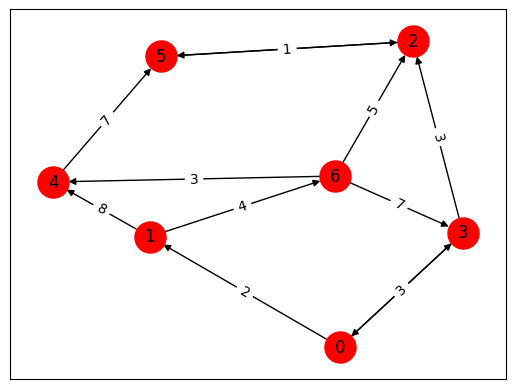

In [6]:
gb.viz.draw(m)

In [7]:
Bellman_Ford_single(m, 0)

[0, 2, 6, 3, 9, 7, 6]

Добавить необходимые тесты.

In [8]:
def test_bellman_ford_single():
    # Простой граф (правильный сценарий, для сравнения):
    m1 = Matrix(float, 3, 3)
    m1[0, 1] = 1
    m1[1, 2] = 2
    m1[2, 0] = 3
    assert Bellman_Ford_single(m1, 0) == [0, 1, 3]


    # Пустая матрица (ожидаем ошибку):
    m2 = Matrix(float, 0, 0)
    try:
        Bellman_Ford_single(m2, 0)
        print("Обработан неверно!!!")
    except IndexError:
        print("Обнаружен пустой граф")

    # Неверный начальный узел (индекс за пределами диапазона):
    m3 = Matrix(float, 3, 3)
    m3[0, 1] = 1
    m3[1, 2] = 2
    m3[2, 0] = 3
    try:
        Bellman_Ford_single(m3, 3)
        print("Обработан неверно!!!")
    except IndexError:
        print("Обнаружен недопустимый начальный узел")

In [9]:
test_bellman_ford_single()

Обнаружен пустой граф
Обнаружен недопустимый начальный узел


Используя python-graphblas реализовать функцию **поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.**
+ Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
+ Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [10]:
def get_results(v, ss):
    res = []
    for i in range(v.nrows):
        row = []
        for j in range(v.ncols):
            if v[i, j].value is None:
                row.append(float('inf'))  # добавляем бесконечность, если значение None
            else:
                row.append(v[i, j].value)  # добавляем значение, если оно не None
        res.append((ss[i], row))
    return res

In [11]:
def Bellman_Ford_multi(m, ss):

    for i in range(m.nrows):
        m[i, i] << 0
    v = Matrix(m.dtype, len(ss), m.nrows)
    # начальные расстояния от начальных вершин до самих себя = нулю:
    for (i, s) in enumerate(ss):
        v[i, s] << 0
    while True:
        w = v.dup()
        v << v.mxm(m, semiring.min_plus) # используем полукольцо min-plus
        # если граф не проходит проверку на ориентированность:
        if v.isequal(w):
            break

    return get_results(v, ss)

Добавить необходимые тесты.

In [12]:
def test_bellman_ford_multi():

    # Пустая матрица (ожидаем ошибку):
    m1 = Matrix(float, 0, 0)
    try:
        Bellman_Ford_single(m1, 0)
        print("Обработан неверно!!!")
    except IndexError:
        print("Обнаружен пустой граф")

    # Некорректная структура данных в списке начальных вершин:
    m2 = Matrix(float, 3, 3)
    try:
        Bellman_Ford_multi(m2, [0, 1, 2, 3])
        print(" Неправильные начальные вершины не обнаружены")
    except IndexError:
        print("Обнаружены неправильные начальные вершины")

test_bellman_ford_multi()

Обнаружен пустой граф
Обнаружены неправильные начальные вершины


Используя python-graphblas реализовать **две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания)**.
+ Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно).
+ Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [13]:
def Floyd_Warshall(m):

    d = m.dup()
    for i in range(d.nrows):
        d[i, i] << 0
    for j in range(m.ncols):
    # обновляем матрицу, учитывая промежуточные вершины
        d(accum=op.min) << d[:, [j]].mxm(d[[j], :], semiring.min_plus)

    return get_results(d, list(range(m.ncols)))

In [14]:
def Transitive_Closure(m):

    identity_matrix = Matrix(m.dtype, m.nrows, m.nrows)
    for i in range(m.nrows):
        m[i, i] << 0
        identity_matrix[i, i] << 1

    d = identity_matrix.dup()
    v = identity_matrix.dup()

    for k in range(m.ncols):
        d << d.mxm(m, semiring.min_plus)
        # обновляем матрицу v, накапливая минимальные значения:
        v(accum=op.min) << d

    for i in range(m.nrows):
        for j in range(m.nrows):
            if v[i, j].value is not None:
                v[i, j] << v[i, j].value - 1

    return get_results(v, list(range(m.ncols)))

Добавить необходимые тесты.

In [15]:
def test_Floyd_Warshall():
    m = Matrix(float, 3, 3)
    m[0, 1] = 2  # ребро (0, 1) с весом 2
    m[1, 2] = 3  # ребро (1, 2) с весом 3
    m[0, 2] = 4  # ребро (0, 2) с весом 4

    # Вызываем функцию Floyd_Warshall
    result = Floyd_Warshall(m)

    # Преобразуем результат в матрицу
    result_matrix = [[float('inf')] * 3 for _ in range(3)]
    for vertex, distances in result:
        for i, distance in enumerate(distances):
            result_matrix[vertex][i] = distance

    # Ожидаемый результат
    expected_result = [
        [0, 2, 4],
        [float('inf'), 0, 3],
        [float('inf'), float('inf'), 0]
    ]

    # Проверяем, что результат соответствует ожидаемому результату
    assert result_matrix == expected_result
    print("Функция Floyd_Warshall работает корректно")

test_Floyd_Warshall()

Функция Floyd_Warshall работает корректно


In [16]:
def test_Transitive_Closure():
    m = Matrix(float, 3, 3)
    m[0, 1] = 2  # ребро (0, 1) с весом 2
    m[1, 2] = 3  # ребро (1, 2) с весом 3
    m[0, 2] = 4  # ребро (0, 2) с весом 4

    # Вызываем функцию Floyd_Warshall
    result = Transitive_Closure(m)

    # Преобразуем результат в матрицу
    result_matrix = [[float('inf')] * 3 for _ in range(3)]
    for vertex, distances in result:
        for i, distance in enumerate(distances):
            result_matrix[vertex][i] = distance

    # Ожидаемый результат
    expected_result = [
        [0, 2, 4],
        [float('inf'), 0, 3],
        [float('inf'), float('inf'), 0]
    ]

    # Проверяем, что результат соответствует ожидаемому результату
    assert result_matrix == expected_result
    print("Функция Transitive_Closure работает корректно")

test_Transitive_Closure()

Функция Transitive_Closure работает корректно
